In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer

import pprint
import warnings
warnings.filterwarnings('ignore')

### Data pre-processing

In [2]:
data = pd.read_csv('../mlcourse.ai/data/credit_scoring_sample.csv', sep=';')

First, let's see what types of data exist in the dataframe

In [3]:
print(data.dtypes) ## returns a Series so we can perform more pandas methods
print(data.dtypes.value_counts())

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object
int64      5
float64    3
dtype: int64


Let's search for 'NaN' values, identify which columns have them, and replace with the `mean` of each column

In [4]:
has_nan = {}
for col in data.columns:
    has_nan[col] = data[col].isnull().any()
    
pprint.pprint(has_nan) ## data pretty printer to view dictionary in a more readable format

{'DebtRatio': False,
 'MonthlyIncome': True,
 'NumberOfDependents': True,
 'NumberOfTime30-59DaysPastDueNotWorse': False,
 'NumberOfTime60-89DaysPastDueNotWorse': False,
 'NumberOfTimes90DaysLate': False,
 'SeriousDlqin2yrs': False,
 'age': False}


In [5]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean") ## create imputer for NaN values

imputed_data = imp.fit_transform(data) ## create numpy array of imputed data

new_data = pd.DataFrame(imputed_data, columns=data.columns) ## make new Dataframe

The dataframe `new_data` has columns only in `float64`, but we want to convert most to `int64` types

In [6]:
## create list of column names not named 'DebtRatio' and 'MonthlyIncome'
int_cols = [col for col in list(new_data.columns) if col not in ['DebtRatio', 'MonthlyIncome']]

In [7]:
## convert columns listed above will be converted to 'int64'
for i_col in int_cols:
    new_data[i_col] = new_data[i_col].astype('int64')

new_data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                        int64
dtype: object

Let's see the distribution of data in 'SeriousDlqin2yrs'

Text(0.5,1,'Serious Delinquency in 2 Years')

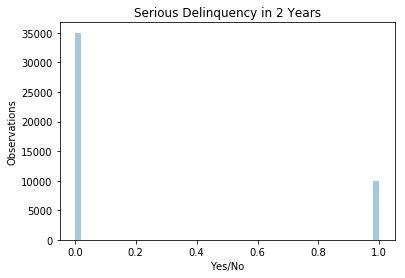

In [8]:
ax = new_data['SeriousDlqin2yrs']
sns.distplot(ax, kde=False)
plt.xlabel('Yes/No')
plt.ylabel('Observations')
plt.title('Serious Delinquency in 2 Years')

Class '0' is ~3x more represented in the dataset than Class '1'. We need to make sure we use a 'balanced' class weight when constructing a decision tree.

Let's set 'SeriousDlqin2yrs' as the target and maintain the rest of the data as inputs

In [9]:
y = new_data.pop('SeriousDlqin2yrs')
X = new_data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [75]:
print(X_train.shape, y_train.shape)

(31544, 7) (31544,)


## Making a decision tree

### Tuning Hyperparameters

In [17]:
tree = DecisionTreeClassifier(class_weight='balanced')

feat_len = len(new_data.columns)
depths = range(5,10)
features = range(feat_len-4, feat_len)

tree_params = {'max_depth': depths,
               'max_features': features}

skf = StratifiedKFold(5, shuffle=True) ## shuffling ensures bootstrapping

Before setting up our hyperparameters, let's see how our basic tree performs

In [33]:
initial_cv_scores = cross_val_score(tree, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)

print(np.mean(initial_cv_scores))

0.6567757567371342


Now let's optimize our hyperparameters by performing a grid search based on `max_depth` and `max_features`

In [18]:
tree_grid = GridSearchCV(tree, tree_params, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

In [19]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(5, 10), 'max_features': range(3, 7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

Here are the best parameters and associated mean cross-validation score:

In [20]:
f'Best tree parameters: {tree_grid.best_params_}'

"Best tree parameters: {'max_depth': 7, 'max_features': 5}"

In [21]:
f'Best ROC-AUC score: {tree_grid.best_score_}'

'Best ROC-AUC score: 0.8205460925205553'

How does our test set perform?

In [32]:
tree_grid.score(X_test, y_test)

0.8344361670082251

## Making a random forest classifier to take advantage of ensembling

In [35]:
forest = RandomForestClassifier(class_weight='balanced')

forest_depths = range(5,15)
forest_params = {'max_depth': forest_depths, 'max_features': features}

In [37]:
forest_grid = GridSearchCV(forest, forest_params, cv= skf, scoring= 'roc_auc', n_jobs= -1, verbose= 1)

In [39]:
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   59.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(5, 15), 'max_features': range(3, 7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [45]:
print('Best RFC params: {} \nBest RFC scores: {}'.format(forest_grid.best_params_, forest_grid.best_score_))

Best RFC params: {'max_depth': 8, 'max_features': 4} 
Best RFC scores: 0.8288024031027579


In [46]:
forest_grid.score(X_test, y_test)

0.8337082599171689

## Using Logistic Regression and Random Forests

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

In [85]:
data2 = pd.read_csv("../mlcourse.ai/data/movie_reviews_train.csv", nrows=50000)
data2.head()

,label,text
0,1,"To an entire generation of filmgoers, it just ..."
1,1,Pixar classic is one of the best kids' movies ...
2,1,Apesar de representar um imenso avanço tecnoló...
3,1,"When Woody perks up in the opening scene, it's..."
4,1,Introduced not one but two indelible character...


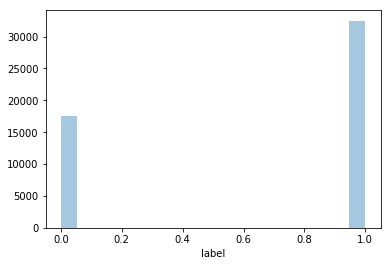

In [86]:
sns.distplot(data2.label, kde=False)

In [87]:
y2 = data2.pop('label')
X2 = data2.text ## this is necessary or the countVectorizer considers all data as a single sample
Xtext_train, Xtext_test, ytext_train, ytext_test = train_test_split(X2, y2, test_size=0.2)

In [88]:
print(Xtext_train.shape, ytext_train.shape)
print(Xtext_train.shape, Xtext_test.shape)

(40000,) (40000,)
(40000,) (10000,)


In [89]:
clf_pipeline = Pipeline([('vectorizer', CountVectorizer(max_features=10000, ngram_range=(1,3))),
                         ('forest', RandomForestClassifier())])

clf_features = [0.1, 0.3, 0.5, 0.7]

pipeline_params = {'forest__max_features': clf_features}

In [90]:
grid_search = GridSearchCV(clf_pipeline, pipeline_params, scoring='roc_auc', cv=skf, verbose=1, n_jobs=-1)

In [91]:
grid_search.fit(Xtext_train, ytext_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 10.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
      ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'forest__max_features': [0.1, 0.3, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [92]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'forest__max_features': 0.1}
0.7432789237875437


In [93]:
grid_search.score(Xtext_test, ytext_test)

0.7456266081078256